In [1]:
import tensorflow as tf 
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import scipy.fft as sc

In [2]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
def rescaleframe(frame, scale = 0.75):
    width = int(frame.shape[1] * scale)
    height = int(frame.shape[0] * scale)
    dimensions = (width, height)
    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)

In [117]:
def rescaleframe_pixel(frame, col, row):
    width = int(col)
    height = int(row)
    dimensions = (width, height)
    return cv.resize(frame, dimensions, interpolation=cv.INTER_AREA)

In [4]:
def centroide(image):
    length = image.shape[0]
    vec = np.linspace(0, length-1, length)
    col_signal = np.sum(image, axis=0)/255 #columna
    row_signal = np.sum(image, axis=1)/255 #fila
    Cx = np.dot(vec, col_signal) / sum(col_signal)
    Cy = np.dot(vec, row_signal) / sum(row_signal)
    return Cx, Cy

In [5]:
def sign(img):
    img = rescaleframe(img, scale=1.5)
    img_blur = cv.blur(img, ksize=(3, 3))
    img_can = cv.Canny(img_blur, 40, 100)
    contours, lista = cv.findContours(img_can, mode=cv.RETR_EXTERNAL, method=cv.CHAIN_APPROX_NONE)
    
    dist = []
    for con in contours:
        dist.append(np.sum(con))
    max_pos = np.argmax(dist)
    main_signal = contours[max_pos].squeeze()
    
    Cx, Cy = centroide(img)
    x, y = np.array_split(main_signal, 2, axis=1)
    mag_x = np.power(Cx-x, 2)
    mag_y = np.power(Cy-y, 2)
    mag = np.power(mag_x + mag_y, 0.5)
    return mag

In [297]:
X = []
Y = []
contador = {}
num_images_per_num = 4000
for i in range(0, 10):
    idx = str(i)
    contador[idx] = 0

for i, x in enumerate(x_train):
    y = y_train[i]
    idx = str(y)
    if contador[idx] < num_images_per_num:
        X.append(x)
        Y.append(y)
        contador[idx] = contador[idx] + 1
    else:
        continue

In [298]:
def one_hot_encoder(idx):
    vec = []
    for i in range(0, 10):
        if i == idx:
            vec.append(1)
        else:
            vec.append(0)
    return vec

In [299]:
target = [one_hot_encoder(Y_value) for Y_value in Y]

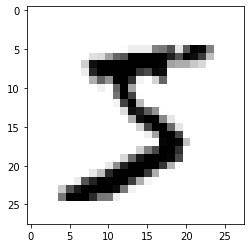

In [300]:
plt.imshow(X[0], cmap=plt.cm.binary)
plt.show()

In [301]:
col = np.sum(X[0], axis=0)
row = np.sum(X[0], axis=1)

In [302]:
def cut(histogram):
    val_ant = 0
    cut_begin = []
    cut_end = []
    mag = []
    for i in range(0, len(histogram)):
        val_act = histogram[i]
        if val_act > 0 and val_ant == 0:
            cut_begin.append(i)
        if val_act == 0 and val_ant > 0:
            cut_end.append(i)
        val_ant = histogram[i]
    for x, y in zip(cut_begin, cut_end):
        mag.append(y - x)
    pos = np.argmax(mag)
    begin = cut_begin[pos]
    end = cut_end[pos]
    return begin, end 

In [303]:
def delete_ops(image):
    col_add = np.zeros((image.shape[0], 1))
    row_add = np.zeros((1, image.shape[1]+2))
    image_add_col = np.concatenate((col_add, image, col_add), axis=1)
    image_add_row = np.concatenate((row_add, image_add_col, row_add), axis=0)
    col = np.sum(image_add_row, axis=0)
    row = np.sum(image_add_row, axis=1)
    cut_row = cut(row)
    cut_col = cut(col)
    img = image[cut_row[0]:cut_row[1], cut_col[0]:cut_col[1]]
    img_res = rescaleframe_pixel(img, 14, 14)
    return img_res

In [304]:
img_del = delete_ops(X[1243])
t, img_th= cv.threshold(img_del, thresh=50, maxval=1, type=cv.THRESH_BINARY)

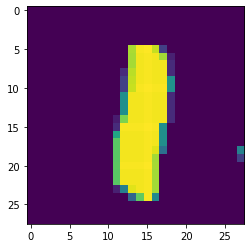

In [305]:
plt.imshow(X[1243])

In [306]:
data_reshaped = []
i = 0
for image in X:
    i = i+1
    t, img_th= cv.threshold(image, thresh=50, maxval=1, type=cv.THRESH_BINARY)
    img_del = delete_ops(img_th)
    data_reshaped.append(img_del)

In [307]:
data = np.array(data_reshaped)
target = np.array(target)

In [308]:

data = np.float32(data)

In [309]:
data = np.reshape(data, (-1, 14, 14, 1))

In [310]:
print(data.shape, target.shape)

(40000, 14, 14, 1) (40000, 10)


In [294]:
droprate = 0.1
cnn = tf.keras.models.Sequential()
cnn.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, padding="same", activation="relu", input_shape=(14, 14, 1)))
cnn.add(tf.keras.layers.Dropout(droprate))
cnn.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, padding="same", activation="relu"))
cnn.add(tf.keras.layers.Dropout(droprate))
cnn.add(tf.keras.layers.MaxPooling2D(pool_size=2, strides=2))
cnn.add(tf.keras.layers.Dropout(droprate))
cnn.add(tf.keras.layers.Flatten())
cnn.add(tf.keras.layers.Dense(units=128, activation="relu"))
cnn.add(tf.keras.layers.Dense(units=64, activation="relu"))
cnn.add(tf.keras.layers.Dense(units=32, activation="relu"))
cnn.add(tf.keras.layers.Dense(units=10, activation="sigmoid"))
cnn.compile(optimizer="adam", loss="binary_crossentropy", metrics="accuracy")

In [315]:
cnn.fit(data, target, batch_size=4, epochs=2, verbose=1)

Epoch 1/2
10000/10000 [==============================] - 70s 7ms/step - loss: 0.0055 - accuracy: 0.9928
Epoch 2/2
10000/10000 [==============================] - 78s 8ms/step - loss: 0.0055 - accuracy: 0.9933
